In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

In [4]:
from data import get_batch
from meta_optimizer import MetaModel, FastMetaOptimizer, MetaOptimizer, LearningRateOnlyMetaOptimizer
from model import ModelBasic, ModelFullyConnected, ModelConvolutional
from utils import copy_params
from time import time

In [5]:
USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

In [6]:
def cuda_wrapper(torch_obj):
    if USE_CUDA:
        return torch_obj.cuda()
    else:
        return torch_obj

In [7]:
losses = {}
test_losses = {}
times = {}

In [145]:
batch_size = 32
test_batch_size = 32
truncated_bptt_step = 1
max_epoch = 20
fast_meta_opt = False
lr_only = True
replay_trajectory = False
num_layers = 2
hidden_size = 10
do_validation = False

In [16]:
kwargs = {'num_workers': 1, 'pin_memory': True} if USE_CUDA else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

In [17]:
Model = ModelConvolutional
num_hidden = 2
model_kwargs = {
    'num_hidden': num_hidden, 
    'fc_hidden_size': 256, 
    'dropout_rate': 0.5, 
    'num_filters': 16, 
    'filter_size': 3
}
model_name = 'conv' + '_num_hidden=' + str(num_hidden)
#model_name = '_'.join(['fc'] + [key + '=' + str(val) for key, val in model_kwargs.items()])
print(model_name)

In [ ]:
Model = ModelFullyConnected
num_hidden = 2
model_kwargs = {
    'num_hidden': num_hidden, 
    'hidden_size': 256, 
    'dropout_rate': 0.8
}
model_name = '_'.join(['fc'] + [key + '=' + str(val) for key, val in model_kwargs.items()])
print(model_name)

In [31]:
losses[model_name] = {}
test_losses[model_name] = {}
times[model_name] = {}

fc_num_hidden=2_hidden_size=256_dropout_rate=0.8


In [140]:
model_name

'fc_num_hidden=2_hidden_size=256_dropout_rate=0.8'

In [146]:
torch.manual_seed(123)

#meta_opt_names = []

run_count = 1

start_lr = 0.01
opt_name = 'meta' + '_start_lr=' + str(start_lr) + '_bptt_steps=' + str(truncated_bptt_step) + '_batch_size=' + str(batch_size)
#meta_opt_names.append(opt_name)

losses[model_name][opt_name] = []
test_losses[model_name][opt_name] = []
times[model_name][opt_name] = []
    
for run in range(run_count):
    losses[model_name][opt_name].append([])
    test_losses[model_name][opt_name].append([])
    times[model_name][opt_name].append([])
    
    # Create a meta optimizer that wraps a model into a meta model
    # to keep track of the meta updates.
    meta_model = cuda_wrapper(Model(**model_kwargs))

    if lr_only:
        meta_optimizer = cuda_wrapper(
            LearningRateOnlyMetaOptimizer(MetaModel(meta_model), num_layers, hidden_size, initial_learning_rate=start_lr)
        )
    elif fast_meta_opt:
        meta_optimizer = cuda_wrapper(FastMetaOptimizer(MetaModel(meta_model), num_layers, hidden_size))
    else:
        meta_optimizer = cuda_wrapper(MetaOptimizer(MetaModel(meta_model), num_layers, hidden_size))

    optimizer = optim.Adam(meta_optimizer.parameters())

    # Sample a new model
    model = cuda_wrapper(Model(**model_kwargs))
            
    if replay_trajectory:
        backup_model = cuda_wrapper(Model(**model_kwargs))

    d = 1

    start_time = time()
    
    av_loss = 0
    av_test_loss = 0
    alpha = 0.999
    
    print('run {} of {}'.format(run + 1, run_count))
    
    #grads = []

    for epoch in range(max_epoch):
        cum_loss = 0.
        step_count = 0
        for step, (x, y) in enumerate(train_loader):
            if step % truncated_bptt_step == 0:
                # Keep states for truncated BPTT
                meta_optimizer.reset_lstm(
                    keep_states=((step>0) or (epoch>0)), model=model, use_cuda=USE_CUDA
                )

                if replay_trajectory:
                    #meta_optimizer.backup_model_params()
                    copy_params(source=model, dest=backup_model)
                    
                #loss_sum = Variable(cuda_wrapper(torch.zeros(1)), requires_grad=True)
            
            x, y = Variable(cuda_wrapper(x)), Variable(cuda_wrapper(y))

            # First we need to compute the gradients of the model
            f_x = model(x)
            loss = F.nll_loss(f_x, y)
            model.zero_grad()
            loss.backward()
            #grads_prod = 0
            #if grads:
            #    for i, param in enumerate(model.parameters()):
            #        grads_prod += torch.sum(grads[i] * param.grad.data.view(-1))
            #        grads[i] = param.grad.data.view(-1)
            #else:
            #    for i, param in enumerate(model.parameters()):
            #        grads.append(param.grad.data.view(-1))

            if not replay_trajectory:
                cum_loss += loss.data[0]
                losses[model_name][opt_name][run].append(loss.data[0])
                av_loss = alpha * av_loss + (1 - alpha) * loss.data[0]
                
            # Perfom a meta update using gradients from model
            # and return the current meta model saved in the optimizer
            meta_model = meta_optimizer.meta_update(model, loss.data)

            # Compute a loss for a step the meta optimizer
            f_x = meta_model(x)
            loss = F.nll_loss(f_x, y)

            #loss_sum = loss_sum + loss

            if (step + 1) % truncated_bptt_step == 0:
                # Update the parameters of the meta optimizer
                meta_optimizer.zero_grad()
                #loss_sum.backward()     # Optimize the sum of losses on the trajectory, or just the last loss?
                loss.backward()
                for param in meta_optimizer.parameters():
                    param.grad.data.clamp_(-1, 1)
                    #print(param.grad.data[0], grads_prod)
                optimizer.step()
                
                if replay_trajectory:
                    meta_optimizer.reset_lstm(
                        keep_states=((step>0) or (epoch>0)), model=model, use_cuda=USE_CUDA
                    )
                    copy_params(source=backup_model, dest=model)

                    for j in range(truncated_bptt_step):
                        train_iter = iter(train_loader)
                        try:
                            x, y = next(train_iter)
                        except StopIteration:
                            train_iter = iter(train_loader)
                            x, y = next(train_iter)

                        x, y = Variable(cuda_wrapper(x)), Variable(cuda_wrapper(y))

                        # First we need to compute the gradients of the model
                        f_x = model(x)
                        loss = F.nll_loss(f_x, y)
                        model.zero_grad()
                        loss.backward()

                        # Perfom a meta update using gradients from model
                        # and return the current meta model saved in the optimizer
                        meta_model = meta_optimizer.meta_update(model, loss.data)
                        
                        cum_loss += loss.data[0]
                        losses[model_name][opt_name][run].append(loss.data[0])
                        
            step_count += 1
            times[model_name][opt_name][run].append(time() - start_time)

        #av_loss = cum_loss / step_count

        # Validation:
        if do_validation:
            cum_test_loss = 0.
            step_count = 0
            for step, (x, y) in enumerate(test_loader):
                x, y = Variable(cuda_wrapper(x)), Variable(cuda_wrapper(y))
        
                f_x = model(x)
                loss = F.nll_loss(f_x, y)
            
                cum_test_loss += loss.data[0]
                test_losses[model_name][opt_name][run].append(loss.data[0])
                av_test_loss = alpha * av_test_loss + (1 - alpha) * loss.data[0]
            
                step_count += 1
            #av_test_loss = cum_test_loss / step_count
        
        if lr_only:
            meta_optimizer.learning_rate.clamp(min=1e-8)
            print('epoch {}; av_loss = {:.3f}; av_test_loss = {:.3f}; lr = {:.4f}'.format(
                epoch+1, av_loss, av_test_loss, meta_optimizer.learning_rate.data[0]
            ))
        else:
            print('epoch {}; av_loss = {:.3f}; av_test_loss = {:.3f}'.format(epoch+1, av_loss, av_test_loss))
        if av_loss < 0.1**d:
            print(
                'model reached loss < 1e-{} in {} epochs ({:.1f}s)'.format(
                    d, epoch+1, time() - start_time
                )
            )
            #if d >= 3:
            #    break
            d += 1
    print(times[model_name][opt_name][-1])
    print()
            
losses[model_name][opt_name] = np.array(losses[model_name][opt_name])
test_losses[model_name][opt_name] = np.array(test_losses[model_name][opt_name])
times[model_name][opt_name] = np.array(times[model_name][opt_name])


run 1 of 1
epoch 1; av_loss = 0.193; av_test_loss = 0.000; lr = 0.1683
epoch 2; av_loss = 0.121; av_test_loss = 0.000; lr = 0.1903
epoch 3; av_loss = 0.081; av_test_loss = 0.000; lr = 0.1933
model reached loss < 1e-1 in 3 epochs (34.7s)
epoch 4; av_loss = 0.057; av_test_loss = 0.000; lr = 0.2008
epoch 5; av_loss = 0.045; av_test_loss = 0.000; lr = 0.1711
epoch 6; av_loss = 0.032; av_test_loss = 0.000; lr = 0.1556
epoch 7; av_loss = 0.023; av_test_loss = 0.000; lr = 0.1446
epoch 8; av_loss = 0.016; av_test_loss = 0.000; lr = 0.1602
epoch 9; av_loss = 0.012; av_test_loss = 0.000; lr = 0.1504
epoch 10; av_loss = 0.008; av_test_loss = 0.000; lr = 0.1337
model reached loss < 1e-2 in 10 epochs (115.6s)
epoch 11; av_loss = 0.007; av_test_loss = 0.000; lr = 0.1505
epoch 12; av_loss = 0.007; av_test_loss = 0.000; lr = 0.1250
epoch 13; av_loss = 0.004; av_test_loss = 0.000; lr = 0.1523
epoch 14; av_loss = 0.003; av_test_loss = 0.000; lr = 0.1159
epoch 15; av_loss = 0.002; av_test_loss = 0.000; l

In [135]:
torch.manual_seed(123)

lr = 0.00001
opt_name_prefixes = ['adam']
#opt_names = []

run_count = 5

for name_prefix in opt_name_prefixes:
    print('{}:'.format(name_prefix))
    opt_name = name_prefix + '_lr=' + str(lr) + '_batch_size=' + str(batch_size)
    opt_names.append(opt_name)

    losses[model_name][opt_name] = []
    test_losses[model_name][opt_name] = []
    times[model_name][opt_name] = []
    
    for run in range(run_count):
        print('run {} of {}'.format(run + 1, run_count))
        start_time = time()
        model = cuda_wrapper(Model(**model_kwargs))
        if name_prefix == 'sgd':
            opt = optim.SGD(model.parameters(), lr=lr)
        elif name_prefix == 'momentum':
            opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        elif name_prefix == 'adam':
            opt = optim.Adam(model.parameters(), lr=lr)
        losses[model_name][opt_name].append([])
        test_losses[model_name][opt_name].append([])
        times[model_name][opt_name].append([])
        alpha = 0.999
        av_loss = 0
        av_test_loss = 0
        for epoch in range(max_epoch * 2):
            cum_loss = 0.
            step_count = 0
            for X, y in train_loader:
                model.zero_grad()
                X, y = Variable(cuda_wrapper(X)), Variable(cuda_wrapper(y))
                prob = model(X)
                loss = F.nll_loss(prob, y)
                loss.backward()
                opt.step()
                losses[model_name][opt_name][run].append(loss.data[0])
                cum_loss += loss.data[0]
                av_loss = alpha * av_loss + (1 - alpha) * loss.data[0]
                step_count += 1
                times[model_name][opt_name][run].append(time() - start_time)
            #av_loss = cum_loss / step_count

            if do_validation:
                cum_test_loss = 0.
                step_count = 0
                for X, y in test_loader:
                    X, y = Variable(cuda_wrapper(X)), Variable(cuda_wrapper(y))
                    prob = model(X)
                    loss = F.nll_loss(prob, y)
                    test_losses[model_name][opt_name][run].append(loss.data[0])
                    cum_test_loss += loss.data[0]
                    av_test_loss = alpha * av_test_loss + (1 - alpha) * loss.data[0]
                    step_count += 1
                #av_test_loss = cum_test_loss / step_count    
        
            print('Epoch {}; av_loss = {:.3f}; av_test_loss = {:.3f}'.format(
                epoch+1, av_loss, av_test_loss
            ))
        print()
        
    print()
    
    losses[model_name][opt_name] = np.array(losses[model_name][opt_name])
    test_losses[model_name][opt_name] = np.array(test_losses[model_name][opt_name])
    times[model_name][opt_name] = np.array(times[model_name][opt_name])


adam:
run 1 of 5
Epoch 1; av_loss = 0.734; av_test_loss = 0.127
Epoch 2; av_loss = 0.442; av_test_loss = 0.184
Epoch 3; av_loss = 0.338; av_test_loss = 0.213
Epoch 4; av_loss = 0.298; av_test_loss = 0.228
Epoch 5; av_loss = 0.269; av_test_loss = 0.233
Epoch 6; av_loss = 0.248; av_test_loss = 0.233
Epoch 7; av_loss = 0.230; av_test_loss = 0.229
Epoch 8; av_loss = 0.217; av_test_loss = 0.224
Epoch 9; av_loss = 0.208; av_test_loss = 0.216
Epoch 10; av_loss = 0.194; av_test_loss = 0.208
Epoch 11; av_loss = 0.180; av_test_loss = 0.200
Epoch 12; av_loss = 0.170; av_test_loss = 0.192
Epoch 13; av_loss = 0.160; av_test_loss = 0.184
Epoch 14; av_loss = 0.154; av_test_loss = 0.176
Epoch 15; av_loss = 0.146; av_test_loss = 0.169
Epoch 16; av_loss = 0.140; av_test_loss = 0.162
Epoch 17; av_loss = 0.133; av_test_loss = 0.155
Epoch 18; av_loss = 0.126; av_test_loss = 0.149
Epoch 19; av_loss = 0.120; av_test_loss = 0.142
Epoch 20; av_loss = 0.117; av_test_loss = 0.137
Epoch 21; av_loss = 0.111; av_te

Epoch 12; av_loss = 0.175; av_test_loss = 0.193
Epoch 13; av_loss = 0.164; av_test_loss = 0.185
Epoch 14; av_loss = 0.156; av_test_loss = 0.177
Epoch 15; av_loss = 0.149; av_test_loss = 0.170
Epoch 16; av_loss = 0.142; av_test_loss = 0.163
Epoch 17; av_loss = 0.136; av_test_loss = 0.157
Epoch 18; av_loss = 0.130; av_test_loss = 0.151
Epoch 19; av_loss = 0.126; av_test_loss = 0.146
Epoch 20; av_loss = 0.121; av_test_loss = 0.140
Epoch 21; av_loss = 0.116; av_test_loss = 0.136
Epoch 22; av_loss = 0.112; av_test_loss = 0.132
Epoch 23; av_loss = 0.105; av_test_loss = 0.128
Epoch 24; av_loss = 0.103; av_test_loss = 0.125
Epoch 25; av_loss = 0.099; av_test_loss = 0.121
Epoch 26; av_loss = 0.095; av_test_loss = 0.118
Epoch 27; av_loss = 0.091; av_test_loss = 0.115
Epoch 28; av_loss = 0.088; av_test_loss = 0.112
Epoch 29; av_loss = 0.085; av_test_loss = 0.109
Epoch 30; av_loss = 0.082; av_test_loss = 0.107
Epoch 31; av_loss = 0.079; av_test_loss = 0.105
Epoch 32; av_loss = 0.076; av_test_loss 

In [92]:
#opt_names
opt_names = opt_names[0:1] + opt_names[2:]

In [45]:
def running_average(a, alpha=0.99):
    #a = np.array(a)
    av = np.zeros_like(a)
    av[0] = a[0]
    for i in range(1, len(a)):
        av[i] = alpha * av[i-1] + (1 - alpha) * a[i]
    return av

In [46]:
alpha = 0.999

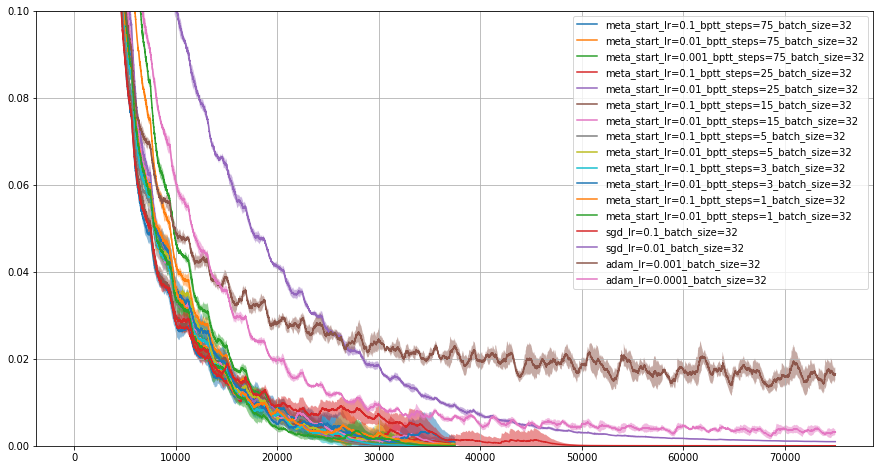

In [128]:
plt.figure(figsize=(15,8))
for opt_name in meta_opt_names + opt_names:
    runs = running_average(losses[model_name][opt_name].T, alpha)
    plt.plot(runs.mean(axis=1))
    plt.fill_between(
        np.arange(runs.shape[0]),
        runs.mean(axis=1) - runs.std(axis=1),
        runs.mean(axis=1) + runs.std(axis=1),
        alpha=0.5
    )
plt.grid(True)
plt.ylim(0.0, 0.1)
plt.legend(meta_opt_names + opt_names)

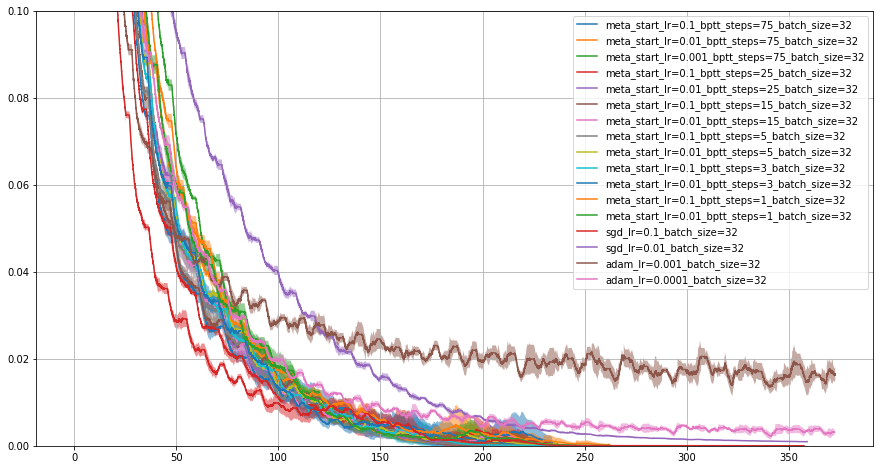

In [127]:
plt.figure(figsize=(15,8))
for opt_name in meta_opt_names + opt_names:
    runs = running_average(losses[model_name][opt_name].T, alpha)
    time_runs = times[model_name][opt_name].T
    plt.plot(time_runs.mean(axis=1), runs.mean(axis=1))
    plt.fill_between(
        time_runs.mean(axis=1),
        runs.mean(axis=1) - runs.std(axis=1),
        runs.mean(axis=1) + runs.std(axis=1),
        alpha=0.5
    )
plt.grid(True)
plt.ylim(0.0, 0.1)
plt.legend(meta_opt_names + opt_names)

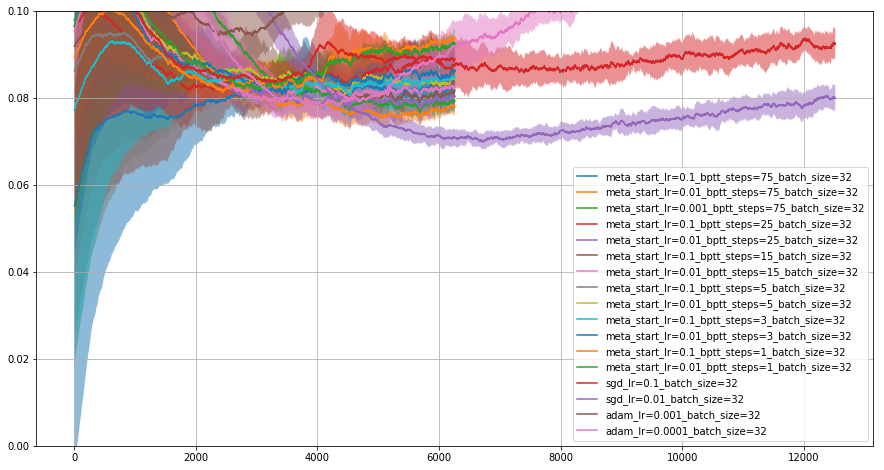

In [129]:
plt.figure(figsize=(15,8))
for opt_name in meta_opt_names + opt_names:
    runs = running_average(test_losses[model_name][opt_name].T, alpha)
    plt.plot(runs.mean(axis=1))
    plt.fill_between(
        np.arange(runs.shape[0]),
        runs.mean(axis=1) - runs.std(axis=1),
        runs.mean(axis=1) + runs.std(axis=1),
        alpha=0.5
    )
plt.grid(True)
plt.ylim(0.0, 0.1)
plt.legend(meta_opt_names + opt_names)

In [130]:
meta_opt_names + opt_names

['meta_start_lr=0.1_bptt_steps=75_batch_size=32',
 'meta_start_lr=0.01_bptt_steps=75_batch_size=32',
 'meta_start_lr=0.001_bptt_steps=75_batch_size=32',
 'meta_start_lr=0.1_bptt_steps=25_batch_size=32',
 'meta_start_lr=0.01_bptt_steps=25_batch_size=32',
 'meta_start_lr=0.1_bptt_steps=15_batch_size=32',
 'meta_start_lr=0.01_bptt_steps=15_batch_size=32',
 'meta_start_lr=0.1_bptt_steps=5_batch_size=32',
 'meta_start_lr=0.01_bptt_steps=5_batch_size=32',
 'meta_start_lr=0.1_bptt_steps=3_batch_size=32',
 'meta_start_lr=0.01_bptt_steps=3_batch_size=32',
 'meta_start_lr=0.1_bptt_steps=1_batch_size=32',
 'meta_start_lr=0.01_bptt_steps=1_batch_size=32',
 'sgd_lr=0.1_batch_size=32',
 'sgd_lr=0.01_batch_size=32',
 'adam_lr=0.001_batch_size=32',
 'adam_lr=0.0001_batch_size=32']

In [133]:
chosen_opt_names = [
    'meta_start_lr=0.1_bptt_steps=75_batch_size=32',
    'meta_start_lr=0.1_bptt_steps=25_batch_size=32',
    'meta_start_lr=0.1_bptt_steps=15_batch_size=32',
    'meta_start_lr=0.1_bptt_steps=5_batch_size=32',
    'meta_start_lr=0.1_bptt_steps=3_batch_size=32',
    'meta_start_lr=0.1_bptt_steps=1_batch_size=32'
]

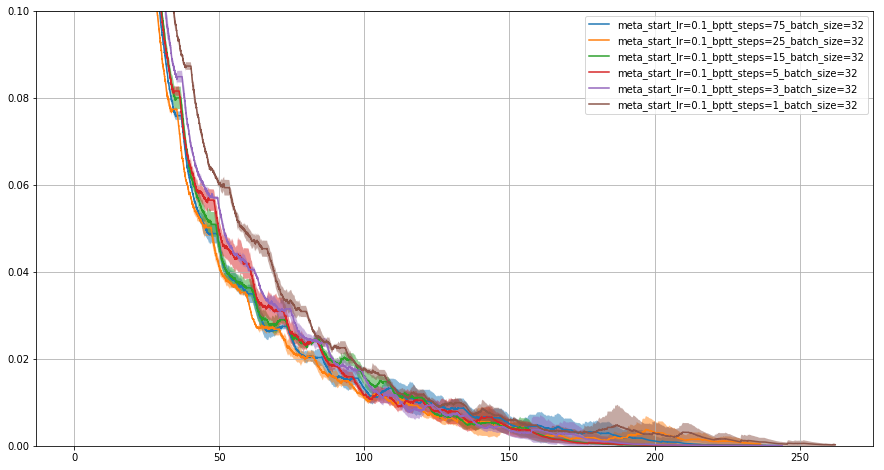

In [134]:
plt.figure(figsize=(15,8))
for opt_name in chosen_opt_names:
    runs = running_average(losses[model_name][opt_name].T, alpha)
    time_runs = times[model_name][opt_name].T
    plt.plot(time_runs.mean(axis=1), runs.mean(axis=1))
    plt.fill_between(
        time_runs.mean(axis=1),
        runs.mean(axis=1) - runs.std(axis=1),
        runs.mean(axis=1) + runs.std(axis=1),
        alpha=0.5
    )
plt.grid(True)
plt.ylim(0.0, 0.1)
plt.legend(chosen_opt_names)